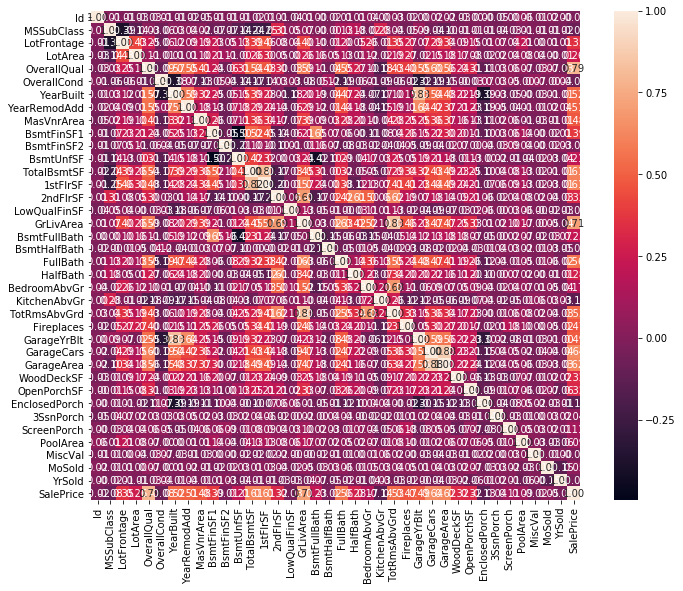

                   Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id           1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass   0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea     -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual -0.028365    0.032628     0.251646  0.105806     1.000000   

             OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id              0.012609  -0.012713     -0.021998   -0.050298   -0.005024   
MSSubClass     -0.059316   0.027850      0.040581    0.022936   -0.069836   
LotFrontage    -0.059213   0.123349      0.088866    0.193458    0.233633   
LotArea        -0.005636   0.014228      0.013788    0.104160    0.214103   
OverallQual    -0.091932   0.572323      0.550684    0.411876    0.239666   

             ...  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
Id           ...   -0.02964

In [107]:
# _*_ codein: utf-8 _*_*
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

train = pd.read_csv('gs://sample_machine_learning_input/HousePrices/train.csv')
test = pd.read_csv('gs://sample_machine_learning_input/HousePrices/test.csv')

train_id = train['Id']
test_id = test['Id']


#sns.jointplot('SalePrice','LotArea',data=train)

#回帰変数の相関
plt.figure(figsize=(12, 9))
sns.heatmap(train.corr(), annot=True, square=True, fmt='.2f')
plt.show()

corr_mat = train.corr(method='pearson')
print(corr_mat.head())

corr_sp = corr_mat['SalePrice']
corr_sp = corr_sp.drop(['Id','SalePrice'],axis=0)
corr_sp = corr_sp.sort_values(ascending=False)

pd.set_option('display.max_rows', 500)
print(corr_sp)


#ラベルを数値化
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))
        
#欠損が多いカラムを削除
train = train.drop(['LotFrontage','MasVnrArea','GarageYrBlt'],axis=1)
test = test.drop(['LotFrontage','MasVnrArea','GarageYrBlt'],axis=1)

y = train['SalePrice']
X = train.drop(['Id','SalePrice'],axis=1)
test = test.drop(['Id'],axis=1)

#トレーニングデータとテストデータを結合
Xmat = pd.concat([X, test])
'''
Xmat = Xmat.loc[:,['OverallQual','GrLivArea','GarageCars','GarageArea',
                  'TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd',
                  'Fireplaces','BsmtFinSF1','WoodDeckSF','2ndFlrSF',
                  'OpenPorchSF','HalfBath','LotArea','BsmtFullBath','BsmtUnfSF']]
'''

#欠損値の少ないカラムのNaNは中央値(median)で埋める
Xmat = Xmat.fillna(Xmat.median())
#trainデータとtestデータを含んでいるXmatを、再度trainデータとtestデータに分割
X = Xmat.iloc[:train.shape[0],:]
test = Xmat.iloc[train.shape[0]:,:]

clf = LinearRegression()
for i in range(10):
    (X_train,X_test,y_train,y_test) = train_test_split(X,y,test_size=0.2,random_state=4)

    clf.fit(X_train,y_train)
    clf.predict(X_test)  #予測値の表示
    print('決定係数: {0}'.format(clf.score(X_test,y_test)))


clf.fit(X,y)
print(clf.coef_)  #回帰変数の表示
print('決定係数: {0}'.format(clf.score(X,y)))
y_test_pred = clf.predict(test)  #予測値の表示



submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": y_test_pred
})
submission.to_csv('gs://sample_machine_learning_output/HousePrices/hp_submission7.csv', index=False)
########


